## 0 - preprocess and build pyspark pipeline

In [3]:
# import subprocess
# import json
# import pandas as pd
# import numpy as np
from pyspark.sql import SparkSession
# import pyspark
# from pyspark import SparkContext as sc
# from pyspark import SparkConf

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, \
                                        GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import matplotlib.pyplot as plt


In [4]:
spark = SparkSession\
        .builder\
        .appName("PySpark ML")\
        .master("local[*]")\
        .getOrCreate()

In [5]:
df = spark\
  .read\
  .option("header", "true")\
  .csv("../data/dynamic_api_call_sequence_per_malware_100_0_306.csv")

In [ ]:
df.printSchema()

In [6]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()
numeric_data = df.select(numeric_features).toPandas()
# drop 'hash' column
df = df.select([col for col in df.columns if col != 'hash'])
cols = df.columns

In [7]:
df.printSchema()

root
 |-- t_0: string (nullable = true)
 |-- t_1: string (nullable = true)
 |-- t_2: string (nullable = true)
 |-- t_3: string (nullable = true)
 |-- t_4: string (nullable = true)
 |-- t_5: string (nullable = true)
 |-- t_6: string (nullable = true)
 |-- t_7: string (nullable = true)
 |-- t_8: string (nullable = true)
 |-- t_9: string (nullable = true)
 |-- t_10: string (nullable = true)
 |-- t_11: string (nullable = true)
 |-- t_12: string (nullable = true)
 |-- t_13: string (nullable = true)
 |-- t_14: string (nullable = true)
 |-- t_15: string (nullable = true)
 |-- t_16: string (nullable = true)
 |-- t_17: string (nullable = true)
 |-- t_18: string (nullable = true)
 |-- t_19: string (nullable = true)
 |-- t_20: string (nullable = true)
 |-- t_21: string (nullable = true)
 |-- t_22: string (nullable = true)
 |-- t_23: string (nullable = true)
 |-- t_24: string (nullable = true)
 |-- t_25: string (nullable = true)
 |-- t_26: string (nullable = true)
 |-- t_27: string (nullable = tru

In [8]:
categoricalColumns = df.columns[:-1]
stages = []
  
for col in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "classVec"])    
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'malware', outputCol = 'label')
stages += [label_stringIdx]

numericCols=[]
# turn all features into a sphare vector
assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [12]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

# set columns
SelCol =  ['label', 'features'] + cols

df = df.select(SelCol)
df.printSchema()
 
#split train & test data
train, test = df.randomSplit([0.8, 0.2], seed = 666)

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- t_0: string (nullable = true)
 |-- t_1: string (nullable = true)
 |-- t_2: string (nullable = true)
 |-- t_3: string (nullable = true)
 |-- t_4: string (nullable = true)
 |-- t_5: string (nullable = true)
 |-- t_6: string (nullable = true)
 |-- t_7: string (nullable = true)
 |-- t_8: string (nullable = true)
 |-- t_9: string (nullable = true)
 |-- t_10: string (nullable = true)
 |-- t_11: string (nullable = true)
 |-- t_12: string (nullable = true)
 |-- t_13: string (nullable = true)
 |-- t_14: string (nullable = true)
 |-- t_15: string (nullable = true)
 |-- t_16: string (nullable = true)
 |-- t_17: string (nullable = true)
 |-- t_18: string (nullable = true)
 |-- t_19: string (nullable = true)
 |-- t_20: string (nullable = true)
 |-- t_21: string (nullable = true)
 |-- t_22: string (nullable = true)
 |-- t_23: string (nullable = true)
 |-- t_24: string (nullable = true)
 |-- t_25: string (nullable

In [13]:
df.toPandas()

D:\Users\Cryst\AppData\Local\Programs\Python\Python39\lib\site-packages\pyspark\sql\pandas\conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


,label,features,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99,malware
0,0.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",112,274,158,215,274,158,215,298,...,71,297,135,171,215,35,208,56,71,1
1,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,208,187,208,172,117,172,117,...,81,240,117,71,297,135,171,215,35,1
2,0.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16,110,240,117,240,117,240,117,...,65,112,123,65,112,123,65,113,112,1
3,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,208,187,208,172,117,172,117,...,208,302,208,302,187,208,302,228,302,1
4,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,209,260,40,209,260,141,260,141,260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43871,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,141,260,141,260,141,260,141,260,141,1
43872,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,159,224,82,159,224,82,159,224,82,1
43873,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,260,141,260,141,260,141,260,141,260,1
43874,0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",82,240,117,240,117,240,117,240,...,141,260,141,260,141,260,141,260,141,1


In [27]:
df_selected = df.select(df["features"],df["label"])

In [14]:
df_selected.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(15556,[2,79,161,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[9,83,162,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[14,81,160...|  0.0|
|(15556,[1,79,161,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,81,163,...|  0.0|
|(15556,[7,80,167,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,82,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[3,80,162,...|  0.0|
|(15556,[4,83,164,...|  0.0|
|(15556,[2,79,161,...|  0.0|
|(15556,[0,78,160,...|  0.0|
|(15556,[0,78,160,...|  0.0|
+--------------------+-----+
only showing top 20 rows



## 1 - Simple models 

In [15]:
## 1.  Logistic Regression Model ##

LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = LR.fit(train)
predictions_LR = lrModel.transform(test)
predictions_LR.select('label', 'rawPrediction', 'prediction', 'probability').show(10)


+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[5.02211466877021...|       0.0|[0.99345257620839...|
|  0.0|[4.97244671447410...|       0.0|[0.99312146110542...|
|  0.0|[5.25378233173205...|       0.0|[0.99479947877444...|
|  0.0|[5.25378233173205...|       0.0|[0.99479947877444...|
|  0.0|[4.99399151117902...|       0.0|[0.99326708567291...|
|  0.0|[5.10984432458872...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458872...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458872...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458872...|       0.0|[0.99399920427338...|
|  0.0|[5.10984432458872...|       0.0|[0.99399920427338...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [16]:
## 2.  Decision Tree Classifier ##

DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10)
dtModel = DT.fit(train)
predictions_DT = dtModel.transform(test)
predictions_DT.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+---------------+----------+--------------------+
|label|  rawPrediction|prediction|         probability|
+-----+---------------+----------+--------------------+
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
|  0.0|[33922.0,288.0]|       0.0|[0.99158140894475...|
+-----+---------------+----------+--------------------+
only showing top 10 rows



In [17]:
## 3.   Random Forest Classifier ##

RF = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = RF.fit(train)
predictions_RF = rfModel.transform(test)
predictions_RF.select( 'label', 'rawPrediction', 'prediction', 'probability').show(10)
 

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
|  0.0|[19.6470154298371...|       0.0|[0.98235077149185...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [18]:
## 4.   Gradient-Boosted Tree Classifier ##

GBT = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10)
gbtModel = GBT.fit(train)
predictions_GBT = gbtModel.transform(test)
predictions_GBT.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



Evaluation 4 models

In [51]:
evaluator = BinaryClassificationEvaluator()
AUC_LR0 = evaluator.evaluate(predictions_LR)
AUC_DT0 = evaluator.evaluate(predictions_DT)
AUC_RF0 = evaluator.evaluate(predictions_RF)
AUC_GBT0 = evaluator.evaluate(predictions_GBT)

print('AUC of Logistic Regression   : ', AUC_LR0)
print('AUC of Decision Tree         : ', AUC_DT0)
print('AUC of Random Forest         : ', AUC_RF0)
print('AUC of Gradient-Boosted Tree : ', AUC_GBT0)


AUC: Logistic Regression   :  0.8747041397653503
AUC: Decision Tree         :  0.16833932104550658
AUC: Random Forest         :  0.8562425695963067
AUC: Gradient-Boosted Tree :  0.86561762383283


## 02 - K-flod Cross Validation

In [46]:
## 1.  Logistic Regression Model ##

LRparamGrid = ParamGridBuilder().addGrid(LR.maxIter, [0, 1]).build()
cv_LR = CrossValidator(estimator=LR, estimatorParamMaps=LRparamGrid, evaluator=evaluator,
    parallelism=2)#numFolds=3 by default
cv_LRModel = cv_LR.fit(df_selected)
AUC_LR = evaluator.evaluate(cv_LRModel.transform(df_selected))
AUC_LR

0.9643568405128655

In [47]:
## 2.  Decision Tree Classifier ##

DTparamGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(DT.maxBins, [10, 20, 40, 80, 100])
             .build())
cv_DT = CrossValidator(estimator=DT, estimatorParamMaps=DTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_DTModel = cv_DT.fit(df_selected)
AUC_DT = evaluator.evaluate(cv_DTModel.transform(df_selected))
AUC_DT

0.426128551837594

In [50]:
## 3.   Random Forest Classifier ##

RFparamGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [2, 5, 10])
             .addGrid(RF.maxBins, [5, 10, 20])
             .addGrid(RF.numTrees, [5, 20, 50])
             .build())
cv_RF = CrossValidator(estimator=RF, estimatorParamMaps=RFparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_RFModel = cv_RF.fit(df_selected)
AUC_RF = evaluator.evaluate(cv_RFModel.transform(df_selected))
AUC_RF

0.9742577644665706

In [49]:
## 4.   Gradient-Boosted Tree Classifier ##

GBTparamGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 5, 10])
             .addGrid(GBT.maxBins, [10, 20, 40])
             .addGrid(GBT.maxIter, [5, 10, 20])
             .build())
cv_GBT = CrossValidator(estimator=GBT, estimatorParamMaps=GBTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_GBTModel = cv_GBT.fit(df_selected)
AUC_GBT = evaluator.evaluate(cv_GBTModel.transform(df_selected))
AUC_GBT

0.9598756662349962

## 03 - Evaluation and Visualization

In [56]:
labels=['Liner Regression','Decision Tree','Random Forest','Gradient Boosting Tree']
raw_performance=[AUC_LR0,AUC_DT0,AUC_RF0,AUC_GBT0]
after_3fold=[AUC_LR,AUC_DT,AUC_RF,AUC_GBT]

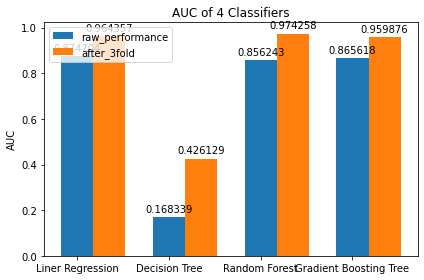

In [57]:
x = np.arange(len(labels))
# x=[float(i+1) for i in range(len(labels))]
width = 0.35  # the width of the bars
y = x + width

fig, ax = plt.subplots()
rects1 = ax.bar(x, raw_performance, width, label='raw_performance')
rects2 = ax.bar(y, after_3fold, width, label='after_3fold')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('AUC of 4 Classifiers')
# ax.set_xticks(x,labels)
# x_ticks_label
# ax.set_xticks(list(x), ax.x_ticks_label[::5])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [33]:
# evaluator.evaluate(cv_LRModel.transform(df_selected))

0.9643576742438813

cross validation on Decision tree

In [36]:
DTparamGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [2, 5, 10, 20, 30])
             .addGrid(DT.maxBins, [10, 20, 40, 80, 100])
             .build())
cv_DT = CrossValidator(estimator=DT, estimatorParamMaps=DTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_DTModel = cv_DT.fit(df_selected)
eva_DT = evaluator.evaluate(cv_DTModel.transform(df_selected))
eva_DT

3

In [37]:
# evaluator.evaluate(cv_DTModel.transform(df_selected))

0.9643558876774189

In [39]:
# Random forest
RFparamGrid = (ParamGridBuilder()
             .addGrid(RF.maxDepth, [2, 5, 10])
             .addGrid(RF.maxBins, [5, 10, 20])
             .addGrid(RF.numTrees, [5, 20, 50])
             .build())
cv_RF = CrossValidator(estimator=RF, estimatorParamMaps=RFparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_RFModel = cv_RF.fit(df_selected)
eva_RF = evaluator.evaluate(cv_DTModel.transform(df_selected))
eva_RF

0.5

In [40]:
# evaluator.evaluate(cv_DTModel.transform(df_selected))

0.964359385016615

In [41]:
# GBT
GBTparamGrid = (ParamGridBuilder()
             .addGrid(GBT.maxDepth, [2, 5, 10])
             .addGrid(GBT.maxBins, [10, 20, 40])
             .addGrid(GBT.maxIter, [5, 10, 20])
             .build())
cv_GBT = CrossValidator(estimator=GBT, estimatorParamMaps=GBTparamGrid, evaluator=evaluator,
    parallelism=2) #numFolds=3 by default
cv_GBTModel = cv_GBT.fit(df_selected)
eva_GBT = evaluator.evaluate(cv_GBTModel.transform(df_selected))
eva_GBT

NameError: name 'cv_GBTModel' is not defined

In [42]:
# cv_GBTModel = cv.fit(df_selected)
# cv_GBTModel.avgMetrics[0]

0.5

In [43]:
# evaluator.evaluate(cv_GBTModel.transform(df_selected))

0.9643588761158651

In [44]:
type(cv_GBTModel)

pyspark.ml.tuning.CrossValidatorModel

In [45]:
cv_GBTModel.avgMetrics

[0.5, 0.9449876618096822]

In [ ]:
LRparamGrid = ParamGridBuilder().addGrid(LR.maxIter, [0, 1]).build()
cv_LR = CrossValidator(estimator=LR, estimatorParamMaps=LRparamGrid, evaluator=evaluator,
    parallelism=1)#numFolds=3 by default
cv_LRModel2 = cv_LR.fit(df_selected)
cv_LRModel2.avgMetrics[0]

In [59]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
MPC = MultilayerPerceptronClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10)
mpcModel = MPC.fit(train)
predictions_MPC = mpcModel.transform(test)
predictions_MPC.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
|  0.0|[1.28793849755033...|       0.0|[0.92929283514093...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows



In [60]:
mpcModel = MPC.fit(train)
predictions_MPC = mpcModel.transform(test)
predictions_MPC.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

Py4JJavaError: An error occurred while calling o87034.fit.
: java.util.NoSuchElementException: Failed to find a default value for layers
	at org.apache.spark.ml.param.Params.$anonfun$getOrDefault$2(params.scala:756)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.ml.param.Params.getOrDefault(params.scala:756)
	at org.apache.spark.ml.param.Params.getOrDefault$(params.scala:753)
	at org.apache.spark.ml.PipelineStage.getOrDefault(Pipeline.scala:41)
	at org.apache.spark.ml.param.Params.$(params.scala:762)
	at org.apache.spark.ml.param.Params.$$(params.scala:762)
	at org.apache.spark.ml.PipelineStage.$(Pipeline.scala:41)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.$anonfun$train$1(MultilayerPerceptronClassifier.scala:190)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:184)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:93)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:151)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:

from pyspark.ml.classification import GBTClassifier
GBT = GBTClassifier(featuresCol = 'features', labelCol = 'label',maxIter=10)
gbtModel = GBT.fit(train)
predictions_GBT = gbtModel.transform(test)
predictions_GBT.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

In [ ]:
from sparkflow.graph_utils import build_graph
from sparkflow.tensorflow_async import SparkAsyncDL
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.pipeline import Pipeline
from pyspark.sql import SparkSession

In [ ]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras import layers,losses,optimizers,regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1 import keras
from tensorflow.compat.v1.keras.models import Sequential
from tensorflow.compat.v1.keras.models import load_model
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras import losses,optimizers,regularizers
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
# import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
def small_model():
    model = keras.Sequential()
    model.add(layers.Dense(output_dim, kernel_initializer='uniform', input_shape=(10,)))
    model.add(layers.Activation('softmax'))
    loss_fn = keras.losses.SparseCategoricalCrossentropy()
    model.compile(loss=loss_fn, optimizer='adam')
    return model
#     loss = model.loss.fn(y_true, model.output)
#     y_true = tf.compat.v1.placeholder(dtype=tf.float32, shape=(None, output_dim))

In [ ]:
# def small_model():
#     x = tf.placeholder(tf.float32, shape=[None, 784], name='x')
#     y = tf.placeholder(tf.float32, shape=[None, 10], name='y')
#     layer1 = tf.layers.dense(x, 256, activation=tf.nn.relu)
#     layer2 = tf.layers.dense(layer1, 256, activation=tf.nn.relu)
#     out = tf.layers.dense(layer2, 10)
#     z = tf.argmax(out, 1, name='out')
#     loss = tf.losses.softmax_cross_entropy(y, out)
#     return loss

In [ ]:
# nb_classes = train.select('label').distinct().count()
# input_dim = len(train.select('features').first()[0])
input_dim=24
output_dim=2

In [ ]:
# def small_model():
#     model = Sequential()
#     model.add(Dense(256,input_shape=(input_dim,),activity_regularizer=regularizers.l2(0.01)))
#     model.add(Activation('relu'))
#     model.add(Dropout(rate=0.3))
#     model.add(Dense(256,activity_regularizer=regularizers.l2(0.01)))
#     model.add(Activation('relu'))
#     model.add(Dropout(rate=0.3))
#     model.add(Dense(nb_classes))
#     model.add(Activation('sigmoid'))
#     model.compile(loss='binart_crossentropy',optimizer='adam')
#     return model

In [ ]:
y_true=test.select('label')
y_true_df = y_true.toPandas()

In [ ]:
model=small_model()
loss = model.loss.fn(y_true_df, model.output)
mg = build_graph(lambda:loss)

In [ ]:
tf.train.export_meta_graph()

In [ ]:
y_true_df = y_true.toPandas()

In [ ]:
y_true_df

In [ ]:
tf.constant(df)